The goal of this project is to predict the genre (either Rap or R&B) of a song solely based off of the song's lyrics. To get song lyric data, I scraped https://www.musixmatch.com/. The website was very sensitive to making many requests in a short period of time, so my scraping script takes a lot of pauses and was used in batches to collect songs from 10-20 albums of each genre at a time. There was also a very big problem with albums listing the same song several times in a row with slightly different lyrics listed. I had to take several measures in my code to fix problems associated with this.

In [ ]:
#imports
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
df = pd.read_csv('rap_r&b.csv') #load table

In [ ]:
#drop unnecessary columns from table
df = df.drop('Unnamed: 0', axis=1)
df = df.drop_duplicates(subset=['Title'], ignore_index=True)
df = df.drop_duplicates(subset=['Lyrics'], ignore_index=True)
df = df.dropna(how='any')

In [ ]:
#clean text for analysis/training
punc = "!()-[]{};:\,<>./?@#$%^&*_~"
def clean(text): 
  for letter in str(text):
    if letter in punc:  
        text = text.replace(letter, "")
  return(str(text).lower())

In [ ]:
df['Lyrics'] = df['Lyrics'].map(lambda text: clean(text))

In [ ]:
df

,Title,Lyrics,Genre
0,anxiety,at the end of the day i still thank god for ev...,Rap
1,conversations,oh my god ronny the devil hit my phone he wan...,Rap
2,titanic,dy definitely krazy abandon all ships its abo...,Rap
3,bad energy,uh uh uhuh uhuh uh uh daytrip took it to ten h...,Rap
4,righteous,i will will i will i will i will uh uh all w...,Rap
...,...,...,...
1941,mad russian,wop mmmmurda i still fuck her like a mad russ...,Rap
1942,hard feelings,southside on the track yeah evil genius gucci ...,Rap
1943,lord,dy krazy lord wop its gucci im praying to the...,Rap
1944,money callin,guwap huh hah evil genius hah guwap guwap fre...,Rap


First, we can remove stopwords, or words that are very commonly used and don't provide much information in regards to understanding sentiment of text.

In [ ]:
nltk.download("stopwords")
swords = set(stopwords.words("english"))
swords = [i.replace("'", "") for i in swords] #remove apostrophes from stopwords to match the removal from the lyrics

def remove_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in swords]
  return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['Lyrics'] = df['Lyrics'].map(lambda text: remove_stopwords(text))

The first bit of analysis I wanted to do was to look at how the most commonly used words in each genre vary

In [ ]:
def count_words(column):
  count = Counter()
  for lyrics in column.values:
    for word in lyrics.split():
      count[word] += 1
  return count

In [ ]:
counter_all = count_words(df['Lyrics'])
rap_counter = count_words(df.loc[df['Genre'] == 'Rap']['Lyrics'])
rb_counter = count_words(df.loc[df['Genre'] == 'R&B']['Lyrics'])

rap_common_words = []
rap_common_words_counts = []
rb_common_words = []
rb_common_words_counts = []

for i in range(10):
  rap_common_words.append(rap_counter.most_common(10)[i][0])
  rap_common_words_counts.append(rap_counter.most_common(10)[i][1])
  rb_common_words.append(rb_counter.most_common(10)[i][0])
  rb_common_words_counts.append(rb_counter.most_common(10)[i][1])

Text(0.5, 1.0, "R&B's 10 Most Common Words")

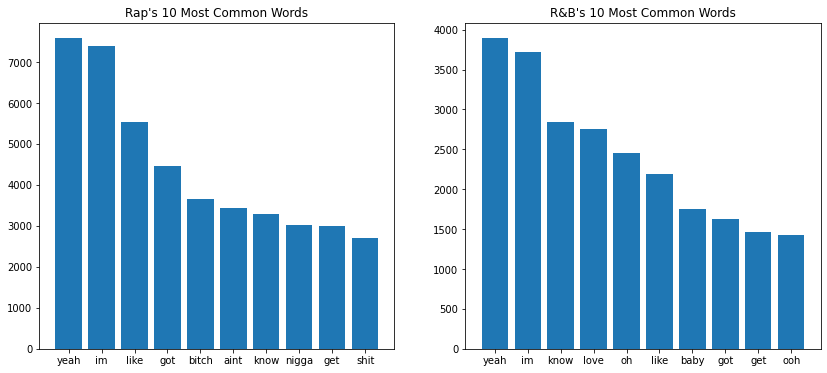

In [ ]:
#create plots
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.bar(rap_common_words, rap_common_words_counts)
plt.title("Rap's 10 Most Common Words")
plt.subplot(1, 2, 2)
plt.bar(rb_common_words, rb_common_words_counts)
plt.title("R&B's 10 Most Common Words")

At this point, I realized that I could probably get away with not using every word in each song to train my RNN, and I could instead use certain keywords that are more or less distinct to each genre. To accomplish this, I decided (after testing many different values) to define our dictionary of words to be the 50 most common words in Rap and the 50 most common words in R&B. I removed every word not in this dictionary from each song's lyrics. This simplified our model by a massive margin, resulting in it being much more efficient and accurate.

In [ ]:
num_words_included = 50

In [ ]:
rb_most_common = rb_counter.most_common(num_words_included)
rap_most_common = rap_counter.most_common(num_words_included)
most_common = []

for i in range(num_words_included):
  most_common.append(rb_most_common[i][0])
  most_common.append(rap_most_common[i][0])
most_common = list(set(most_common)) #make sure list is unique

In [ ]:
def remove_uncommon_words(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() in most_common]
  return " ".join(filtered_words)

In [ ]:
df['Lyrics'] = df['Lyrics'].map(lambda text: remove_uncommon_words(text))

In [ ]:
df = df.dropna(how='any') #drop columns that became empty after removal of words
df

,Title,Lyrics,Genre
0,anxiety,still know put money like know good got money ...,Rap
1,conversations,oh hit wanna im gotta make see back im got got...,Rap
2,titanic,go im right good good yeah show got gotta keep...,Rap
3,bad energy,uh uh uh uh see got keep night said im feel li...,Rap
4,righteous,uh uh im yeah know yeah right yeah yeah ooh ti...,Rap
...,...,...,...
1941,mad russian,still fuck like hit got cause aint yeah one on...,Rap
1942,hard feelings,yeah go aint get got em show got money need co...,Rap
1943,lord,im get see uh im know see im get see huh im kn...,Rap
1944,money callin,huh im huh im ive ive money like em uh get huh...,Rap


Now it is time to set up the data for the model

In [ ]:
num_unique_words = len(most_common)
max_length = df['Lyrics'].str.split().str.len().max() #determine max word count of all words remaining in songs

In [ ]:
df['Genre'] = df['Genre'].replace({'Rap': 0, 'R&B': 1}) #encode labels

In [ ]:
df

,Title,Lyrics,Genre
0,anxiety,still know put money like know good got money ...,0
1,conversations,oh hit wanna im gotta make see back im got got...,0
2,titanic,go im right good good yeah show got gotta keep...,0
3,bad energy,uh uh uh uh see got keep night said im feel li...,0
4,righteous,uh uh im yeah know yeah right yeah yeah ooh ti...,0
...,...,...,...
1941,mad russian,still fuck like hit got cause aint yeah one on...,0
1942,hard feelings,yeah go aint get got em show got money need co...,0
1943,lord,im get see uh im know see im get see huh im kn...,0
1944,money callin,huh im huh im ive ive money like em uh get huh...,0


I created this histogram to better determine an acceptable input size for our RNN (shown later in code). I ended up determining that 75 words was a good size.

(array([174., 308., 447., 423., 275., 180.,  85.,  29.]),
 array([  0,  25,  50,  75, 100, 125, 150, 175, 200]),
 <a list of 8 Patch objects>)

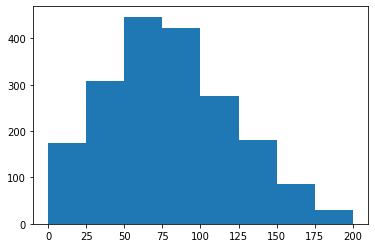

In [ ]:
df['totalwords'] = df['Lyrics'].str.split().str.len()
plt.hist(df.totalwords, bins=[0,25,50,75,100,125,150,175,200])

In [ ]:
X = df[['Lyrics']]
y = df['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#tokenize the text to convert to numeric values for model
tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(X_train['Lyrics'])
windex = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train['Lyrics'])
X_test = tokenizer.texts_to_sequences(X_test['Lyrics'])

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

#pad text for model
X_train = pad_sequences(X_train, maxlen=75, padding="post", truncating="post") #maxlen will be our RNN input size (as mentioned previously)
X_test = pad_sequences(X_test, maxlen=75, padding="post", truncating="post")

print(X_train.shape, X_test.shape)

(1556, 75) (389, 75)


In [ ]:
X_train[5] #as we can see everything after the 75th word has been cut off

array([41,  4, 37, 30,  5, 10,  4,  4,  4, 55,  3,  5,  3,  5,  3, 55,  5,
       14, 17, 55, 17, 17, 17, 23, 16, 16,  4, 17, 30,  1,  1, 31, 22, 24,
       16, 16,  3, 35,  2,  2, 24,  3, 35, 56,  2,  3, 28,  7, 17,  3, 16,
       16,  4, 14,  7, 13, 17,  8, 20, 55, 17, 39,  4,  3,  3, 16, 16, 37,
        6, 37, 16, 13, 27,  8, 37], dtype=int32)

Now that the data is ready, we can build and train the model

In [ ]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=75))
model.add(layers.LSTM(64))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 75, 32)            2080      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 26,977
Trainable params: 26,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=0.00025)
metrics = ["accuracy"]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=2)

Epoch 1/20
49/49 - 5s - loss: 0.6784 - accuracy: 0.6542 - val_loss: 0.6474 - val_accuracy: 0.6710
Epoch 2/20
49/49 - 2s - loss: 0.5423 - accuracy: 0.7326 - val_loss: 0.4520 - val_accuracy: 0.8021
Epoch 3/20
49/49 - 2s - loss: 0.4408 - accuracy: 0.8246 - val_loss: 0.4350 - val_accuracy: 0.8149
Epoch 4/20
49/49 - 2s - loss: 0.3959 - accuracy: 0.8380 - val_loss: 0.4207 - val_accuracy: 0.8175
Epoch 5/20
49/49 - 2s - loss: 0.3797 - accuracy: 0.8425 - val_loss: 0.4211 - val_accuracy: 0.8201
Epoch 6/20
49/49 - 2s - loss: 0.3753 - accuracy: 0.8522 - val_loss: 0.4084 - val_accuracy: 0.8303
Epoch 7/20
49/49 - 2s - loss: 0.3663 - accuracy: 0.8522 - val_loss: 0.4205 - val_accuracy: 0.8149
Epoch 8/20
49/49 - 2s - loss: 0.3643 - accuracy: 0.8496 - val_loss: 0.3909 - val_accuracy: 0.8329
Epoch 9/20
49/49 - 2s - loss: 0.3596 - accuracy: 0.8554 - val_loss: 0.3913 - val_accuracy: 0.8226
Epoch 10/20
49/49 - 2s - loss: 0.3564 - accuracy: 0.8528 - val_loss: 0.3688 - val_accuracy: 0.8483
Epoch 11/20
49/49 -

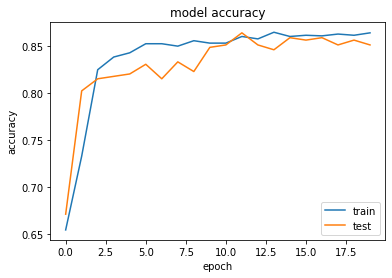

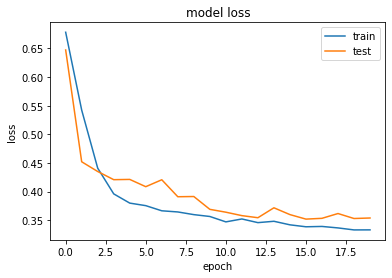

In [ ]:
#plot history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

#plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

The training and testing accuracy are still close in value to one another, so it appears that our model is not overfit

We can now make predictions for new songs

In [ ]:
song_for_prediction = 'https://www.musixmatch.com/lyrics/Kendrick-Lamar/Alright'

#get lyrics
request = urllib.request.Request(song_for_prediction,headers={'User-Agent': user_agent})
html = urllib.request.urlopen(request).read()
match_lyrics = re.search('\"lyrics\":.*?body\":\"(.*?)\",', str(html))
lyrics = match_lyrics.group(1)
lyrics = re.sub(r"\\n", ' ', lyrics)
lyrics = re.sub(r"\\+", '', lyrics)
lyrics_final = re.sub(r"'", "", str(lyrics))

#clean lyrics
lyrics_final = clean(lyrics_final)
lyrics_final = remove_stopwords(lyrics_final)
lyrics_final = remove_uncommon_words(lyrics_final)

#format lyrics to pass into model
lyrics_list_format = [str(lyrics_final)]
lyrics_tokenized = tokenizer.texts_to_sequences(lyrics_list_format)
lyrics_tokenized = np.asarray(lyrics_tokenized)
lyrics_tokenized_and_padded = pad_sequences(lyrics_tokenized, maxlen=75, padding="post", truncating="post")

#predict
if model.predict(lyrics_tokenized_and_padded)[0][0] >= 0.5:
  print('R&B')
else:
  print('Rap')

Rap
